## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️


# How to Evaluate Machine Learning Models: Choosing Performance Metrics

In this Jupyter Notebook, we will explore various performance metrics for evaluating machine learning models. The choice of an evaluation metric is crucial and often depends on the problem being solved. A clear understanding of a wide range of metrics can help identify an appropriate match between the problem statement and a metric.

We will (again) work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

<a name='import'></a>
## Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [131]:
#!pip install pydotplus
#!pip install lifelines

In [132]:
import os
import shap
import sklearn
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

<a name='1'></a>
## 1. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [133]:
path_data = "data"

X = pd.read_csv(os.path.join(path_data, "NHANESI_subset_X.csv"))
y = pd.read_csv(os.path.join(path_data, "NHANESI_subset_y.csv"))

X = X.drop('Unnamed: 0', axis=1)
y = y.drop('Unnamed: 0', axis=1)

X.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0


In [134]:
data = X.copy()
data["time"] = y
data = data.dropna(axis="rows")
data.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,time
0,35.0,92.0,126.0,2.0,77.7,12.0,5.0,165.0,135.0,1.37,7.6,2.0,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,2.0,77.7,37.0,4.0,298.0,89.0,1.38,6.4,2.0,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,2.0,77.7,31.0,3.8,222.0,115.0,1.37,7.4,2.0,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,1.0,77.7,30.0,4.3,265.0,94.0,1.97,7.3,2.0,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,2.0,77.7,18.0,5.0,203.0,192.0,1.35,7.3,1.0,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000


In [135]:
threshold = 10  # we focus on >10 year risk

data["death"] = np.ones(len(data))

# remove all people which haven't died within the study
data.loc[data["time"] < 0, "death"] = 0

# remove data which we can (and should) not use for predicting >10 year risk
mask = (data["time"] > 0) | (data["time"] <= -threshold)
data = data[mask]

# Create data/label split --> X, y
X = data.drop(["death", "time"], axis='columns')
y = (data.time < threshold) & (data.time > 0)  # died within 0 and threshold years

In [136]:
X.shape, y.shape

((8233, 18), (8233,))

## Split data --> Train (70%) + Val (15%) + Test (15%)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=10)

In [138]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                  test_size=0.5, random_state=10)

In [139]:
X_train.shape, X_val.shape, X_test.shape

((5763, 18), (1235, 18), (1235, 18))

In [140]:
# in this context we will also use the c-index to evaluate our models
import lifelines

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

<a name='2'></a>
## 2. Random Forests

Over the last weeks we learned that **random forests**, which combine predictions from many different trees, function as a much more a robust classifier when compared to individual trees. They have a much lower risk of overfitting, and they generally show better prediction performance. 

But even with a **grid search** and a **random search** we were hardly able to get better results than before. Let's see if we can do a little better. Or, where we still have issues we need to fix.

In [141]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=7,
                                min_samples_leaf=5,
                                random_state=10)
# train the model
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

In [142]:
y_train_preds = forest.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = forest.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9212263457303702
Val C-Index: 0.8528283443073461


In [143]:
# compute the accuracy (fraction of correct predictions)
y_predictions = forest.predict(X_val)
# accuracy = correct predictions / total number of data points
accuracy = sum(y_predictions == y_val) / len(y_val)
accuracy


0.8388663967611336

In [144]:
# how many people would our model give the diagnoses "< 10 years survival"? True: Stirbt
# sum(preditcions == True) #oder
pd.DataFrame(y_predictions).value_counts()

False    1210
True       25
dtype: int64

In [145]:
pd.DataFrame(y_val).value_counts()

time 
False    1023
True      212
dtype: int64

#### Der unterschied zwischen der Prediction und der Realität ist trotz der Accuracy nicht gut
#### Hat einen starken Bias und welchen durch unsere Metriken wie C-Index und Accurrcy nicht aufgefallen ist


---
## 1. Model evaluation metrics
### Confusion matrix
The confusion matrix looks like this (considering 1 -Positive and 0 -Negative as the target classes):

|             | Actual 0             | Actual 1             |
| ----------- | -------------------- | -------------------- |
| Predicted 0 | True Negatives (TN)  | False Negatives (FN) |
| Predicted 1 | False Positives (FP) | True Positives (TP)  |

- TN: Number of negative cases correctly classified
- TP: Number of positive cases correctly classified
- FN: Number of positive cases incorrectly classified as negative
- FP: Number of negative cases incorrectly classified as positive

In [146]:
def plot_confusion_matrix(confusion_matrix):
    # Plot the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(6, 4), dpi=50)
    sb.heatmap(conf_matrix, annot=True, annot_kws={"size": 16},
               cmap="Purples",
               fmt="g")

    # Set labels and title
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)
    plt.title('Confusion Matrix', fontsize=20)

    # Show the plot
    plt.show()

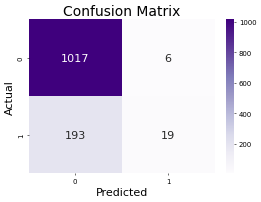

In [147]:
from sklearn import metrics

conf_matrix = metrics.confusion_matrix(y_val,y_predictions)
plot_confusion_matrix(conf_matrix)

Relativ schlechtes Ergebnis, die Acc ist hoch weil die meisten Fälle die TP sind erkannt werden.

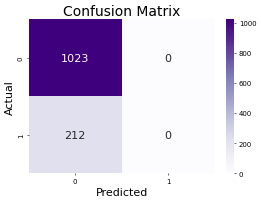

In [148]:
stupid_predictions = np.zeros(len(y_val))
conf_matrix = metrics.confusion_matrix(y_val,stupid_predictions)
plot_confusion_matrix(conf_matrix)

selbst hier würde noch eine hohe acc rausbekommen

### Accuracy
Accuracy is the simplest metric and can be defined as the number of test cases correctly classified divided by the total number of test cases. It can be applied to most generic problems but is not very useful when it comes to unbalanced datasets.

For instance, if we are detecting frauds in bank data, the ratio of fraud to non-fraud cases can be 1:99. In such cases, if accuracy is used, the model will turn out to be 99% accurate by predicting all test cases as non-fraud. The 99% accurate model will be completely useless.

Therefore, for such a case, a metric is required that can focus on the ten fraud data points which were completely missed by the model.

In [149]:
from sklearn import metrics

accuracy_studpid = metrics.accuracy_score(y_val,stupid_predictions)
print("Baseline:", accuracy_studpid) # der score ist hoch obwohl man nur Nullen eingegeben hat - Acc nicht ausreichend

accuracy = metrics.accuracy_score(y_val,y_predictions)
print("Our model:", accuracy) 

#unser model schlägt die Baseline aber nur mit ganz wenig vorsprung

Baseline: 0.8283400809716599
Our model: 0.8388663967611336


### Alternative evaluation metric: concordance

We can also use concordance, or the C-Index for evaluation.

The C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).

More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:

$$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$



### Precision
Precision is the metric used to identify the correctness of classification. Intuitively, this equation is the ratio of correct positive classifications to the total number of predicted positive classifications. The greater the fraction, the higher is the precision, which means better is the ability of the model to correctly classify the positive class.

$$P = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

In the problem of predictive maintenance (where one must predict in advance when a machine needs to be repaired), precision comes into play. The cost of maintenance is usually high, and thus, incorrect predictions can lead to a loss for the company. In such cases, the ability of the model to correctly classify the positive class and to lower the number of false positives is paramount!

In [150]:
precision = metrics.precision_score(y_val,y_predictions)
precision

0.76

### Recall
Recall tells us the number of positive cases correctly identified out of the total number of positive cases.

$$R = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Going back to the fraud problem, the recall value will be very useful in fraud cases because a high recall value will indicate that a lot of fraud cases were identified out of the total number of frauds.

In [151]:
recall = metrics.recall_score(y_val,y_predictions)
recall

0.08962264150943396

### F1 Score
F1 score is the harmonic mean of Recall and Precision and therefore balances out the strengths of each.

$$F_1 = \frac{\text{P} \cdot \text{R}}{\text{P} + \text{R}}$$

It is useful in cases where both recall and precision can be valuable – like in the identification of plane parts that might require repairing. Here, precision will be required to save on the company's cost (because plane parts are extremely expensive), and recall will be required to ensure that the machinery is stable and not a threat to human lives.

In [152]:
f1 = metrics.f1_score(y_val,y_predictions)
f1 # model ist nicht gut balanciert siehe ergebnis

0.16033755274261602

### AUC-ROC

The ROC curve is a plot of the true positive rate (recall) against the false positive rate (TN / (TN+FP)). AUC-ROC stands for Area Under the Receiver Operating Characteristics, and the higher the area, the better the model performance.

If the curve is somewhere near the 50% diagonal line, it suggests that the model randomly predicts the output variable.


First, we need to convert the labels `True` and `False` to 1 and 0 if necessary.

In [153]:
def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()

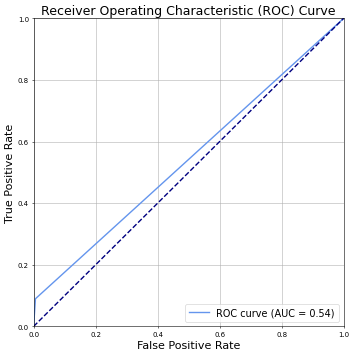

In [154]:
plot_roc_curve(y_val,y_predictions)

Ziel bei dem Graph ist es die AUC möglichst nah an 1 zu bekommen. Meistens eine Kurve

In [155]:
forest.predict(X_val[:10])

array([False, False, False, False, False, False, False, False, False,
        True])

In [156]:
forest.predict_proba(X_val[:10]) #die Wahrscheinlichkeit vor der Vorhersage wird ausgegeben

array([[0.62690526, 0.37309474],
       [0.94662001, 0.05337999],
       [0.97060397, 0.02939603],
       [0.50573858, 0.49426142],
       [0.73681131, 0.26318869],
       [0.96842308, 0.03157692],
       [0.61678071, 0.38321929],
       [0.52382108, 0.47617892],
       [0.66903172, 0.33096828],
       [0.4146701 , 0.5853299 ]])

Wir können nachsteuern indem wir die Grenzen verschieben ab wann das Model true oder false wiedergibt.

In [157]:
y_val[:10]

6455     True
6849    False
9077    False
2369     True
6995    False
8514    False
5917    False
2042     True
2053    False
3383    False
Name: time, dtype: bool

In [158]:
forest.predict_proba(X_val)[:,1] [:10]

array([0.37309474, 0.05337999, 0.02939603, 0.49426142, 0.26318869,
       0.03157692, 0.38321929, 0.47617892, 0.33096828, 0.5853299 ])

In [159]:
forest.predict_proba(X_val)[:,1].mean() #tendenziell sehr niedrige Wahrscheinlichkeiten bei True Vorhersagen

0.15815740199038159

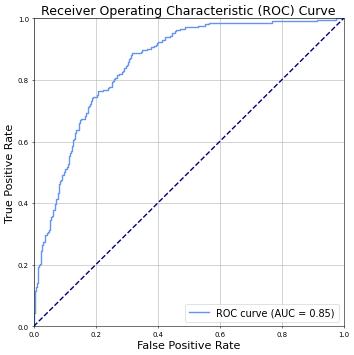

In [160]:
y_predictions_proba = forest.predict_proba(X_val)[:,1]
plot_roc_curve(y_val,y_predictions_proba)

Unser model hatte sich bei dem Graphen oben entschieden den Wert bei 0.1 zu nehmen. Das model will keine false positiv vergeben und wählte deshalb den Punkt. Sehr konservativ. In dieser Kurve sieht man das Potential des Models. Wir können es noch so tunen, dass wir vll weiter in den oberen Bereich kommen.

In [161]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

False    4876
True      887
Name: time, dtype: int64
False    1023
True      212
Name: time, dtype: int64
False    1055
True      180
Name: time, dtype: int64


Starkes Ungleichgewicht in den Daten

Möglichkeiten zum Ausgleichen: 
- Undersampling: Man nimmt von beiden werden nur 887 (Nachteil wir verlieren viele Daten)
- Oversampling: Man vervielfältigt seine Daten

In [162]:
train_data = X_train.copy(deep=True)
train_data["label"]= y_train #zum vermeiden das label und trainingsdaten durcheinander geraten

#Vervielfältigung der Daten
minority_class = train_data[train_data.label == True] #die wenigen Daten mit dem label True
majority_class = train_data[train_data.label == False] #die meisten Daten mit dem label false



In [163]:
print(len(minority_class))
print(len(majority_class))

887
4876


In [164]:
from sklearn.utils import resample

# durch resamble ziehen wir beispiele aus unserem datensatz  (bisschen wie random choice)
minority_class_oversampled = resample(minority_class, n_samples=len(majority_class), replace=True,random_state=0) # replace erlaubt auch das doppelte verwenden von daten
minority_class_oversampled.shape

(4876, 19)

In [165]:
train_data_oversampled = pd.concat([majority_class, minority_class_oversampled])
train_data_oversampled.value_counts("label")

label
False    4876
True     4876
dtype: int64

In [166]:
X_train_oversampled = train_data_oversampled.drop(["label"], axis=1)
y_train_oversampled = train_data_oversampled["label"]


In [167]:
y_train_oversampled.value_counts()

False    4876
True     4876
Name: label, dtype: int64

In [168]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=7,
                                min_samples_leaf=5,
                                random_state=10)
forest.fit(X_train_oversampled,y_train_oversampled)

RandomForestClassifier(max_depth=7, min_samples_leaf=5, random_state=10)

In [169]:
y_predictions_proba_with_oversampling = forest.predict_proba(X_val)[:,1]
y_predictions_with_oversampling = forest.predict(X_val)

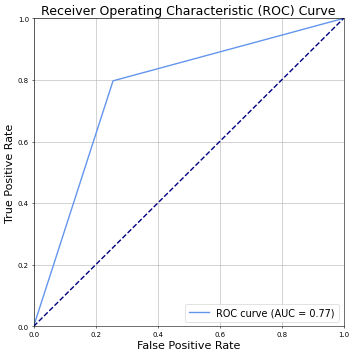

In [170]:
plot_roc_curve(y_val,y_predictions_with_oversampling)

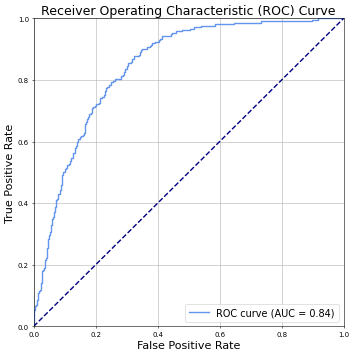

In [171]:
plot_roc_curve(y_val,y_predictions_proba_with_oversampling)

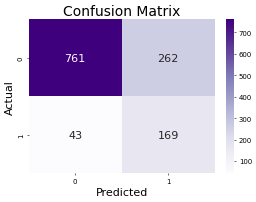

In [172]:
conf_matrix = metrics.confusion_matrix(y_val,y_predictions_with_oversampling)
plot_confusion_matrix(conf_matrix)

Die Erkennungsrate für false negativ geht deutlich runter im Vergleich zu den urspünglichen Daten. Aber dafür steigt die Rate für false positiv. Auch die ROC Curve verlagert sich in den oberen linken Bereich.

In [173]:
class_weights = {False:1, True:5}

forest_weighted = RandomForestClassifier(n_estimators=100,
                                max_depth=7,
                                min_samples_leaf=5,
                                random_state=10,
                                class_weight=class_weights)
forest_weighted.fit(X_train,y_train)

RandomForestClassifier(class_weight={False: 1, True: 5}, max_depth=7,
                       min_samples_leaf=5, random_state=10)

In [174]:
y_predictions_weighted = forest_weighted.predict(X_val)
y_predictions_proba_weighted = forest_weighted.predict_proba(X_val)

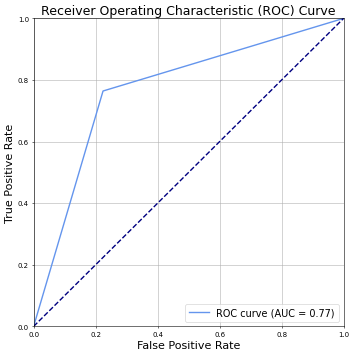

In [175]:
plot_roc_curve(y_val,y_predictions_weighted)

Alternative zum Oversampling. Jetzt steigt die true positiv rate an weil wir diese stärker gewichten. Weniger Aufwand zum Oversampling. Wir können so den Bias in den Daten ausgleichen. Die Einstellung kommt aber darauf an welche Richtung wir stärker gewichten wollen.

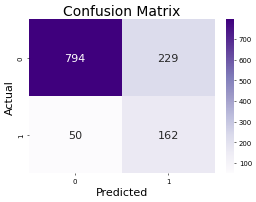

In [176]:
conf_matrix = metrics.confusion_matrix(y_val,y_predictions_weighted)
plot_confusion_matrix(conf_matrix)